In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as trans
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np
import PIL

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from models import fixed_networks as fnet
from utils import gan_utils as gutils
from utils import style_utils as sutils

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# load pretrained loss network, only need feature parts
loss_net = torchvision.models.squeezenet1_1(pretrained=True).features
loss_net.type(dtype)
for param in loss_net.parameters():
    param.requires_grad = False

# load pretrained generators
G_c = fnet.dc_Gen_R_BN()
G_c.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
G_c.type(dtype)
G_c.eval()

G_s = fnet.dc_Gen_R_BN()
G_s.type(dtype)

print("Generator's state_dict:")
for param_tensor in G_c.state_dict():
    print(param_tensor, "\t", G_c.state_dict()[param_tensor].size())

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Generator's state_dict:
0.weight 	 torch.Size([16384, 100])
0.bias 	 torch.Size([16384])
2.weight 	 torch.Size([16384])
2.bias 	 torch.Size([16384])
2.running_mean 	 torch.Size([16384])
2.running_var 	 torch.Size([16384])
4.weight 	 torch.Size([1024, 512, 5, 5])
4.bias 	 torch.Size([512])
6.weight 	 torch.Size([512])
6.bias 	 torch.Size([512])
6.running_mean 	 torch.Size([512])
6.running_var 	 torch.Size([512])
7.weight 	 torch.Size([512, 256, 5, 5])
7.bias 	 torch.Size([256])
9.weight 	 torch.Size([256])
9.bias 	 torch.Size([256])
9.running_mean 	 torch.Size([256])
9.running_var 	 torch.Size([256])
10.weight 	 torch.Size([256, 128, 5, 5])
10.bias 	 torch.Size([128])
12.weight 	 torch.Size([128])
12.bias 	 torch.Size([128])
12.running_mean 	 torch.Size([128])
12.running_var 	 torch.Size([128])
13.weight 	 torch.Size([128, 3, 5, 5])
13.bias 	 torch.Size([3])


In [2]:
import collections
# function for visualization the change of each layer
convlayers = ['4', '7', '10', '13']
G_c_convlayers = collections.defaultdict(list)
for conv in convlayers:
    G_c_convlayers[conv].append(G_c.state_dict()[conv+'.weight'].clone().cpu().detach().numpy())
    G_c_convlayers[conv].append(G_c.state_dict()[conv+'.bias'].clone().cpu().detach().numpy())
    
bnlayers = ['6', '9', '12']
G_c_bnlayers = collections.defaultdict(list)
for bn in bnlayers:
    G_c_bnlayers[bn].append(G_c.state_dict()[bn+'.weight'].clone().cpu().detach().numpy())
    G_c_bnlayers[bn].append(G_c.state_dict()[bn+'.bias'].clone().cpu().detach().numpy())
    G_c_bnlayers[bn].append(G_c.state_dict()[bn+'.running_mean'].clone().cpu().detach().numpy())
    G_c_bnlayers[bn].append(G_c.state_dict()[bn+'.running_var'].clone().cpu().detach().numpy())

def change_of_convlayer(g_c_convlayers, g_s):
    dweight = []
    dbias = []
    for key in g_c_convlayers:
        g_s_weight = g_s.state_dict()[key+'.weight'].clone().cpu().detach().numpy()
        g_s_bias = g_s.state_dict()[key+'.bias'].clone().cpu().detach().numpy()
        dweight.append(np.mean((g_s_weight - g_c_convlayers[key][0])**2) / np.mean(g_c_convlayers[key][0]**2))
        dbias.append(np.mean((g_s_bias - g_c_convlayers[key][1])**2) / np.mean(g_c_convlayers[key][1]**2))
    return dweight, dbias

def change_of_bnlayer(g_c_bnlayers, g_s):
    dweight = []
    dbias = []
    dmean = []
    dvar = []
    for key in g_c_bnlayers:
        g_s_weight = g_s.state_dict()[key+'.weight'].clone().cpu().detach().numpy()
        g_s_bias = g_s.state_dict()[key+'.bias'].clone().cpu().detach().numpy()
        g_s_mean = g_s.state_dict()[key+'.running_mean'].clone().cpu().detach().numpy()
        g_s_var = g_s.state_dict()[key+'.running_var'].clone().cpu().detach().numpy()
        dweight.append(np.mean((g_s_weight - g_c_bnlayers[key][0])**2) / np.mean(g_c_bnlayers[key][0]**2))
        dbias.append(np.mean((g_s_bias - g_c_bnlayers[key][1])**2) / np.mean(g_c_bnlayers[key][1]**2))
        dmean.append(np.mean((g_s_mean - g_c_bnlayers[key][2])**2) / np.mean(g_c_bnlayers[key][2]**2))
        dvar.append(np.mean((g_s_var - g_c_bnlayers[key][3])**2) / np.mean(g_c_bnlayers[key][3]**2))
    return dweight, dbias, dmean, dvar

In [3]:
def show_images(content_images, style_images):
    sqrtn = int(np.ceil(np.sqrt(content_images.shape[0])))
    
    fig = plt.figure(figsize=(2*sqrtn, sqrtn))
    
    gs = gridspec.GridSpec(1, 2)
    gs.update(wspace=0.1, hspace=0.05)
    
    inner = gridspec.GridSpecFromSubplotSpec(sqrtn, sqrtn, subplot_spec=gs[0], wspace=0.05, hspace=0.05)

    for i, img in enumerate(content_images):
        ax = plt.subplot(inner[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.transpose(1, 2, 0))
    
    inner = gridspec.GridSpecFromSubplotSpec(sqrtn, sqrtn, subplot_spec=gs[1], wspace=0.05, hspace=0.05)

    for i, img in enumerate(style_images):
        ax = plt.subplot(inner[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.transpose(1, 2, 0))
    
    return

In [4]:
def train_style(g_c, g_s, batchsize, noize_dim, style_target, style_size, loss_net, 
                style_layers, style_weights, content_layer, content_weight, tv_weight,
                num_iter=51, show_every=50):
    
    # load style target
    style_img = sutils.style_target_preprocess(PIL.Image.open(style_target), size=style_size)
    style_img = style_img.type(dtype)
    style_feats = sutils.extract_features(style_img, loss_net)
    style_grams = []
    for idx in style_layers:
        style_grams.append(sutils.gram_matrix(style_feats[idx].clone()))

    # Set up optimization hyperparameters
    initial_lr = 1e-4
    
    g_s_params = []
    for param in g_s.parameters():
        if param.requires_grad == True:
            g_s_params.append(param)

    optimizer = torch.optim.Adam(g_s_params, lr=initial_lr) # hyperparameters TBD
    
    dw = []
    db = []
    dbnw = []
    dbnb = []
    dbnm = []
    dbnv = []
    
    for t in range(num_iter):
        optimizer.zero_grad()

        # sample latent variable
        z = gutils.input_noise_uniform(batchsize, noize_dim).type(dtype)

        fake_contents = g_c(z).detach()
        fake_images = g_s(z)
        if t % show_every == 0:
            simgs_numpy = gutils.deprocess_img(fake_images.clone().cpu().detach().numpy())
        fake_images_pro = sutils.fake_image_preprocess(fake_images)

        content_target = sutils.extract_features(fake_contents, loss_net)
        content_target = content_target[content_layer].clone()
        fake_feats = sutils.extract_features(fake_images, loss_net)
        
        # Compute loss
        c_loss = sutils.content_loss(content_weight, fake_feats[content_layer], content_target)
        s_loss = sutils.style_loss(fake_feats, style_layers, style_grams, style_weights)
        t_loss = sutils.tv_loss(fake_images, tv_weight)
        loss = c_loss + s_loss + t_loss
        
        loss.backward()        
        optimizer.step()
        
        dweight, dbias = change_of_convlayer(G_c_convlayers, g_s)
        dw.append(dweight)
        db.append(dbias)
        dweight, dbias, dmean, dvar = change_of_bnlayer(G_c_bnlayers, g_s)
        dbnw.append(dweight)
        dbnb.append(dbias)
        dbnm.append(dmean)
        dbnv.append(dvar)

        if t % show_every == 0:
            print('Iter '+str(t)+':')
            cimgs_numpy = gutils.deprocess_img(fake_contents.cpu().numpy())
            show_images(cimgs_numpy[0:64], simgs_numpy[0:64])
            plt.show()
            
    dw = np.array(dw).T
    db = np.array(db).T
    dbnw = np.array(dbnw).T
    dbnb = np.array(dbnb).T
    dbnm = np.array(dbnm).T
    dbnv = np.array(dbnv).T
    x_axis = np.arange(dw.shape[1])
    
    fig = plt.figure(figsize=(10.0, 4.0))
    plt.subplot(1, 2, 1)
    legend = []
    for i in range(dw.shape[0]):
        plt.plot(x_axis, dw[i])
        legend.append('Conv'+str(i+1))
    plt.title('Relative change of Conv layers\' weight')
    plt.legend(legend)
    
    plt.subplot(1, 2, 2)
    legend = []
    for i in range(dw.shape[0]):
        plt.plot(x_axis, db[i])
        legend.append('Conv'+str(i+1))
    plt.title('Relative change of Conv layers\' bias')
    plt.legend(legend)
    fig.savefig('./savefigs/Conv_changes.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    fig = plt.figure(figsize=(10.0, 8.0))
    plt.subplot(2, 2, 1)
    legend = []
    for i in range(dbnw.shape[0]):
        plt.plot(x_axis, dbnw[i])
        legend.append('BN'+str(i+1))
    plt.title('Relative change of BN layers\' weight')
    plt.legend(legend)
    
    plt.subplot(2, 2, 2)
    legend = []
    for i in range(dbnb.shape[0]):
        plt.plot(x_axis, dbnb[i])
        legend.append('BN'+str(i+1))
    plt.title('Relative change of BN layers\' bias')
    plt.legend(legend)
    
    plt.subplot(2, 2, 3)
    legend = []
    for i in range(dbnm.shape[0]):
        plt.plot(x_axis, dbnm[i])
        legend.append('BN'+str(i+1))
    plt.title('Relative change of BN layers\' running mean')
    plt.legend(legend)
    
    plt.subplot(2, 2, 4)
    legend = []
    for i in range(dbnv.shape[0]):
        plt.plot(x_axis, dbnv[i])
        legend.append('BN'+str(i+1))
    plt.title('Relative change of BN layers\' running var')
    plt.legend(legend)
    fig.savefig('./savefigs/BN_changes.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    return

Iter 0:


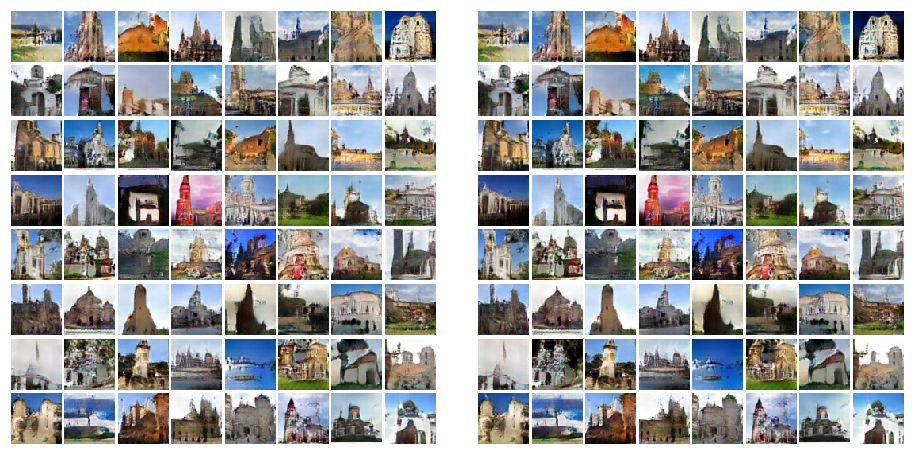

Iter 50:


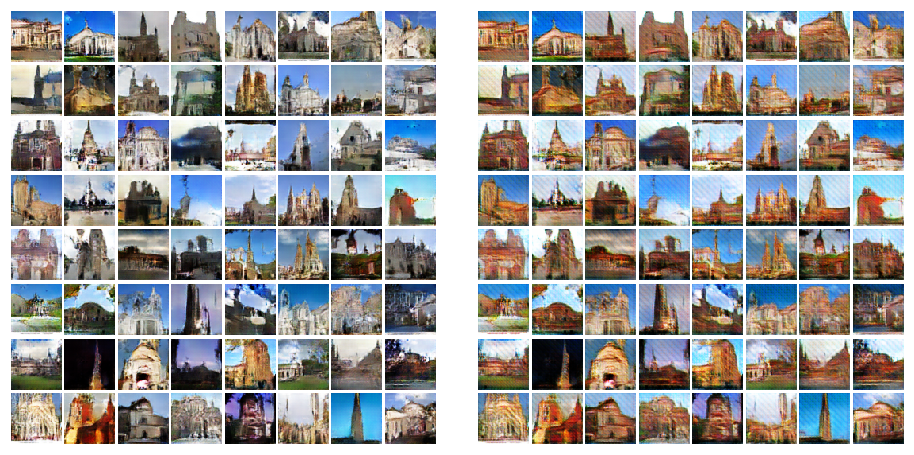

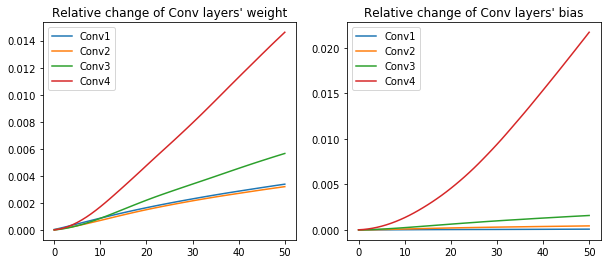

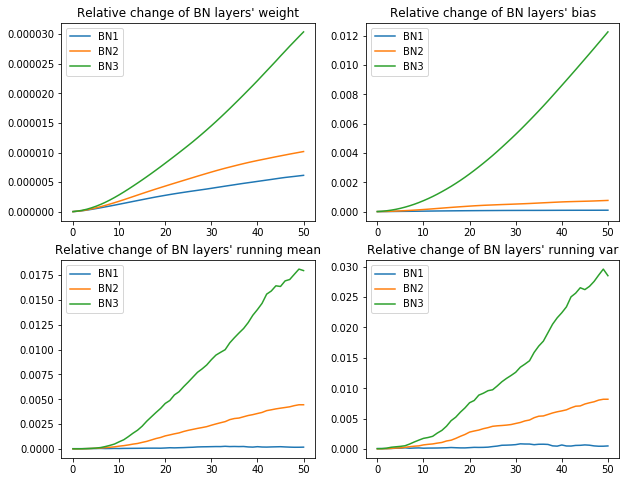

In [5]:
G_s.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
for i, param in enumerate(G_s.parameters()):
    if i > -1:
        param.requires_grad = True
    else:
        param.requires_grad = False

train_style(G_c, G_s, 128, 100, './styles/the_scream.jpg', 250, loss_net, 
            [1, 4, 6, 7], [6000, 240, 3.6, 0.3], 3, 3.5e-1, 2e-3)

Iter 0:


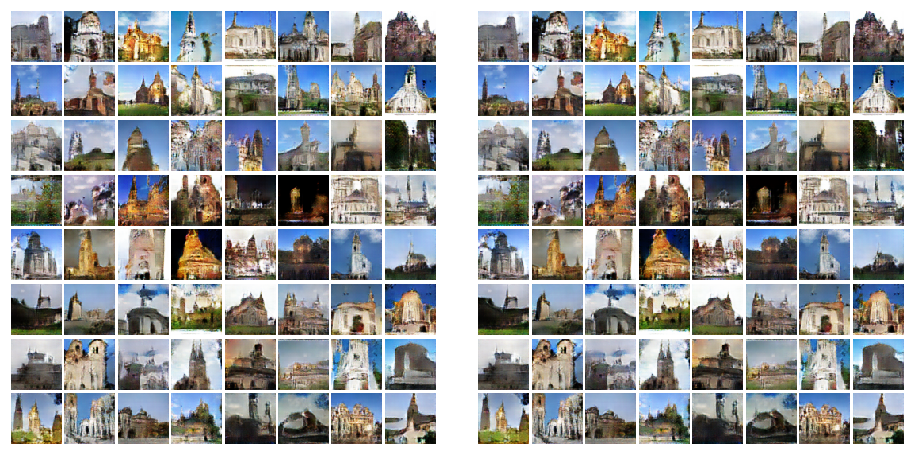

Iter 50:


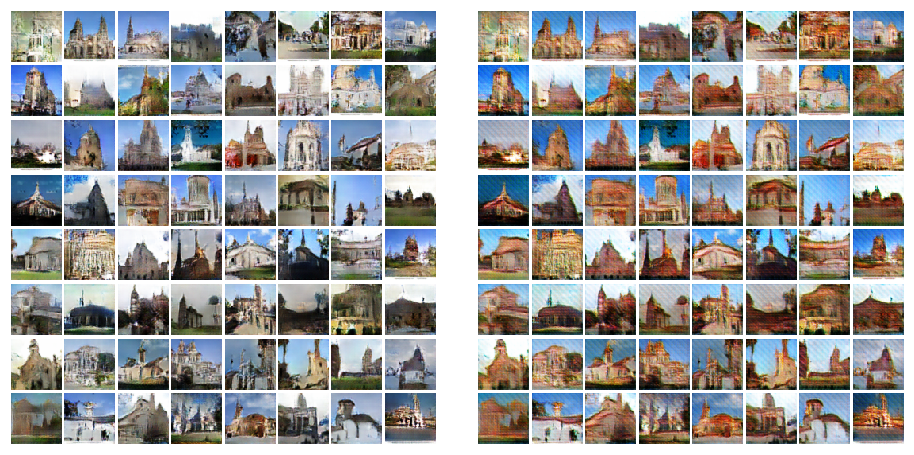

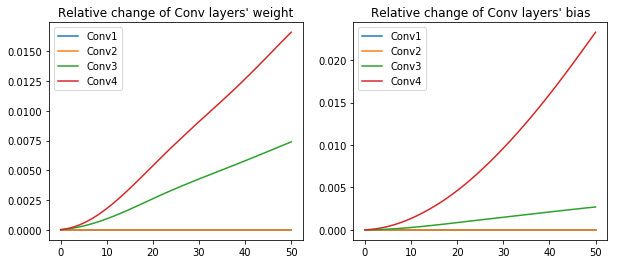

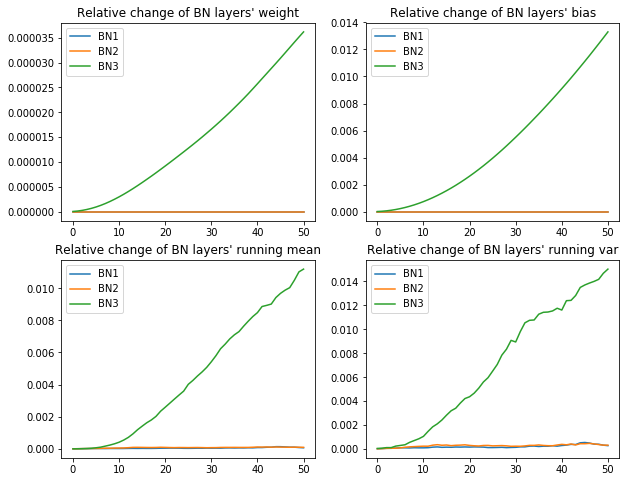

In [7]:
G_s.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
for i, param in enumerate(G_s.parameters()):
    if i > 11:
        param.requires_grad = True
    else:
        param.requires_grad = False

train_style(G_c, G_s, 128, 100, './styles/the_scream.jpg', 250, loss_net, 
            [1, 4, 6, 7], [7000, 280, 4.2, 0.35], 3, 3.5e-1, 2e-3)